# 1. Подготовка

## Данные

В наличии были исторические данные с о заказах такси в аэропортах.

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

График ряда до ресемплирования



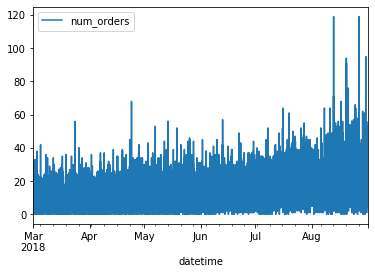

График ряда после ресемплирования


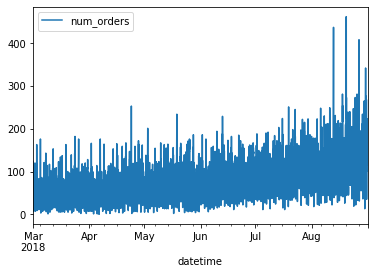

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(data)
print()
print('График ряда до ресемплирования')
print()
data.plot()
plt.show()
data = data.resample('1h').sum()
print('График ряда после ресемплирования')
data.plot()

Данные загружены. Столбец с датой преобразован в индекс. Выполнено ресемплирование данных по одному часу

# 2. Анализ

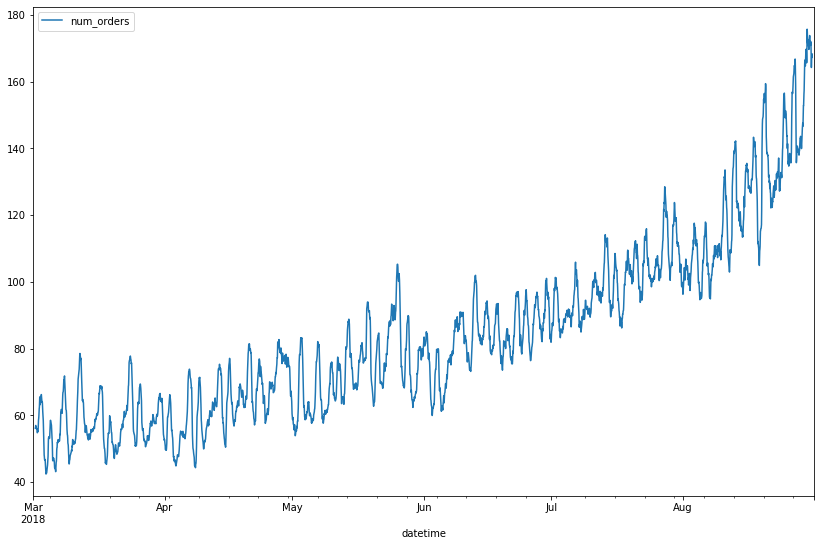

In [2]:
data.sort_index(inplace=True)
decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize=(14, 9))


Виден тренд на увеличение общего числа поездок(от марта к августу).

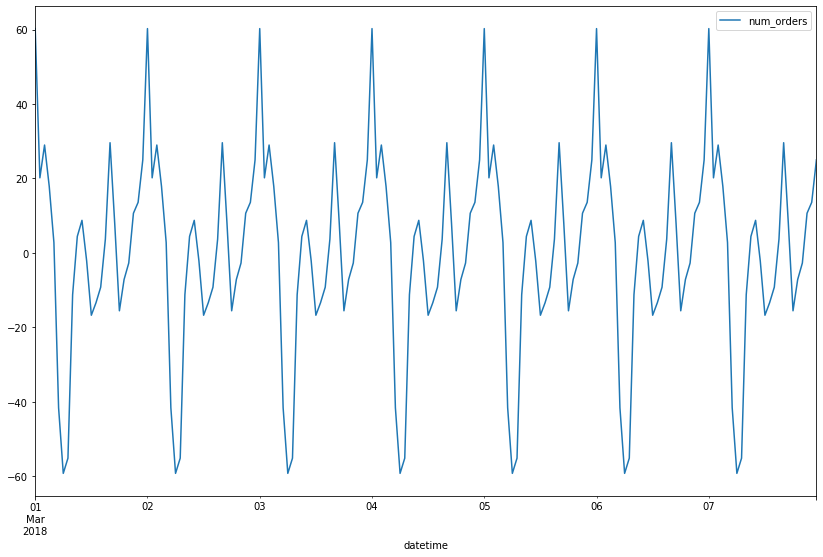

In [3]:
decomposed.seasonal=decomposed.seasonal['2018-03-01':'2018-03-07'] 
decomposed.seasonal.plot(figsize=(14, 9))

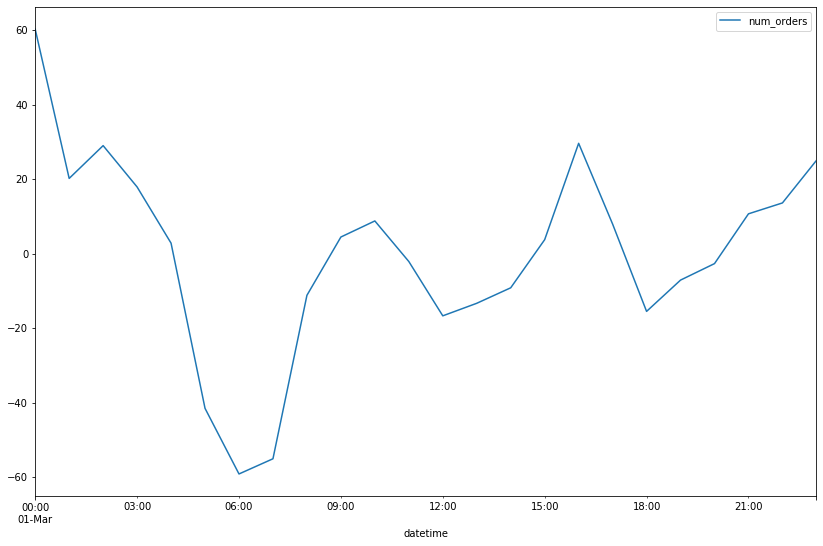

In [4]:
decomposed.seasonal=decomposed.seasonal['2018-03-01':'2018-03-01'] 
decomposed.seasonal.plot(figsize=(14, 9))

Рассмотрим сезонность. Число поездок растет с течением дня, есть пики в 9(все едут на работу), в 15(обеденный перерыв), и рост с 18(все едут с работы, ночью едут после досуга).

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 15, 3)

print(data.head())
print(data.tail())
print(data.info())

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   

                     lag_3  lag_4  lag_5  ...  lag_7  lag_8  lag_9  lag_10  \
datetime                                  ...                                
2018-03-01 00:00:00    NaN    NaN    NaN  ...    NaN    NaN    NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...    NaN    NaN    NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...    NaN    NaN    NaN     NaN   
2018-03-01 03:00:00  124.0    NaN    NaN  ...    NaN    NaN    

Данные преобразованы. Тк данные охватывают период в 1 год(2018) - то год отдельно выделять в признаки не будем. Выделим день, месяц, день недели и время(час).
Добавлено 15 столбцов с отстающими значениями.
Добавлен столбец со скользящим средним с шагом 3.

# 3. Обучение

In [6]:
#удалим пропуски
data=data.dropna()

#delim na viborki
data_valid_train, data_test = train_test_split(data,shuffle=False, test_size=0.1, random_state=12345)
data_train, data_valid = train_test_split(data_valid_train,shuffle=False, test_size=0.1, random_state=12345)




# priznak i cel
features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']
features_test = data_test.drop(['num_orders'], axis=1)
target_test = data_test['num_orders']
features_valid = data_valid.drop(['num_orders'], axis=1)
target_valid = data_valid['num_orders']



Данные поделены на обучающую, валидационную и тестовую выборки.
Пропуски в обучающей выборки из-за недостающих значений удалены.
Целевой признак - num_orders.

Выберем 4 вида моделей(случайный лес, линейная регрессия, CatBoostRegressor, LGBMRegressor) и настроим их гиперпараметры.

In [7]:
print('случайный лес')
    
for depth in range(1,15):
    model = RandomForestRegressor(n_estimators=150, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    train_predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, train_predictions)
    print("depth =", depth, "RMSE:", mse ** 0.5)

случайный лес
depth = 1 RMSE: 50.52699143449073
depth = 2 RMSE: 48.237019207436056
depth = 3 RMSE: 43.13502125397499
depth = 4 RMSE: 40.16475668215869
depth = 5 RMSE: 36.69466197072223
depth = 6 RMSE: 34.5915730075826
depth = 7 RMSE: 33.459958474909136
depth = 8 RMSE: 32.65900952265317
depth = 9 RMSE: 32.27279270112773
depth = 10 RMSE: 31.819288952856432
depth = 11 RMSE: 31.587968864271836
depth = 12 RMSE: 31.532067501145796
depth = 13 RMSE: 31.47597579445921
depth = 14 RMSE: 31.342576378247724


In [8]:
print('линейная регрессия')
model = LinearRegression()
model.fit(features_train, target_train)
train_predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, train_predictions)
print('линейная регрессия', "RMSE:", mse ** 0.5)

линейная регрессия
линейная регрессия RMSE: 39.80432240140013


In [9]:
print('CatBoostRegressor')

for depth in range(1,15):
    model = CatBoostRegressor(loss_function="RMSE", iterations=150, depth=depth, random_state=12345)
    model.fit(features_train, target_train,verbose=50)
    train_predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, train_predictions)
    print("depth =", depth, "RMSE:", mse ** 0.5)
    print()

CatBoostRegressor
0:	learn: 35.8727386	total: 75.5ms	remaining: 11.3s
50:	learn: 30.8957622	total: 366ms	remaining: 711ms
100:	learn: 28.9597061	total: 651ms	remaining: 316ms
149:	learn: 27.8223285	total: 940ms	remaining: 0us
depth = 1 RMSE: 44.99690175369229

0:	learn: 35.8296405	total: 1.92ms	remaining: 286ms
50:	learn: 28.6742415	total: 327ms	remaining: 635ms
100:	learn: 25.9976663	total: 731ms	remaining: 355ms
149:	learn: 24.7025893	total: 1.12s	remaining: 0us
depth = 2 RMSE: 39.89085954645308

0:	learn: 35.7533443	total: 2.1ms	remaining: 313ms
50:	learn: 26.8285942	total: 417ms	remaining: 809ms
100:	learn: 24.2847745	total: 905ms	remaining: 439ms
149:	learn: 23.1037118	total: 1.48s	remaining: 0us
depth = 3 RMSE: 36.816497730272886

0:	learn: 35.7423767	total: 2.28ms	remaining: 339ms
50:	learn: 25.8664449	total: 659ms	remaining: 1.28s
100:	learn: 23.2554453	total: 1.34s	remaining: 653ms
149:	learn: 22.1748009	total: 2.03s	remaining: 0us
depth = 4 RMSE: 35.64055864398779

0:	learn: 

In [10]:
print('LGBMRegressor')

for depth in range(1,15):
    model = lgb.LGBMRegressor(metric='RMSE',num_iterations=150, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train,eval_set=[(features_valid, target_valid)],verbose=50)
    train_predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, train_predictions)
    print("max_depth =", depth, "RMSE:", mse ** 0.5)
    print()

LGBMRegressor


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 44.4279
[100]	valid_0's rmse: 40.3117
[150]	valid_0's rmse: 38.34
max_depth = 1 RMSE: 38.34001189527335



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 36.6865
[100]	valid_0's rmse: 33.4691
[150]	valid_0's rmse: 32.3136
max_depth = 2 RMSE: 32.31359516272616



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 33.2025
[100]	valid_0's rmse: 31.7898
[150]	valid_0's rmse: 31.4841
max_depth = 3 RMSE: 31.484085210413152



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 32.3268
[100]	valid_0's rmse: 31.6695
[150]	valid_0's rmse: 31.6277
max_depth = 4 RMSE: 31.627693430227474



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.9884
[100]	valid_0's rmse: 31.403
[150]	valid_0's rmse: 31.454
max_depth = 5 RMSE: 31.454023454692006



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.5778
[100]	valid_0's rmse: 31.5176
[150]	valid_0's rmse: 31.686
max_depth = 6 RMSE: 31.68601319136952



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.5741
[100]	valid_0's rmse: 31.1554
[150]	valid_0's rmse: 31.3686
max_depth = 7 RMSE: 31.368648560291533



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.2791
[100]	valid_0's rmse: 31.2222
[150]	valid_0's rmse: 31.2532
max_depth = 8 RMSE: 31.2532003993084



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.0208
[100]	valid_0's rmse: 30.817
[150]	valid_0's rmse: 30.8716
max_depth = 9 RMSE: 30.871620389379252



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.3988
[100]	valid_0's rmse: 31.2713
[150]	valid_0's rmse: 31.3279
max_depth = 10 RMSE: 31.327930087875515



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.9207
[100]	valid_0's rmse: 31.7424
[150]	valid_0's rmse: 31.7765
max_depth = 11 RMSE: 31.776483373755667



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.788
[100]	valid_0's rmse: 31.5144
[150]	valid_0's rmse: 31.6693
max_depth = 12 RMSE: 31.66931608564009



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.7507
[100]	valid_0's rmse: 31.7679
[150]	valid_0's rmse: 31.8905
max_depth = 13 RMSE: 31.89051021272868



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.7592
[100]	valid_0's rmse: 31.3272
[150]	valid_0's rmse: 31.5089
max_depth = 14 RMSE: 31.50893537492182



Для финального тестирования возьмем модель с лучшими результатами RMSE каждого вида и проверим на тестовой выборке.
На валидационной выборке лучший результат показала модель LGBMRegressor.

# 4. Тестирование

In [11]:
model_final = RandomForestRegressor(n_estimators=150, max_depth=14, random_state=12345)
model_final.fit(features_train, target_train)
test_predictions = model_final.predict(features_test)
mse_final = mean_squared_error(target_test, test_predictions)
print('RMSE:', mse_final ** 0.5)

RMSE: 47.62100459073429


<font color='green'>Требуемое качество достигнуто. </font>


In [12]:
model_final = LinearRegression()
model_final.fit(features_train, target_train)
test_predictions = model_final.predict(features_test)
mse_final = mean_squared_error(target_test, test_predictions)
print('RMSE:', mse_final ** 0.5)

RMSE: 54.987344190982995


In [13]:
model_final = CatBoostRegressor(loss_function="RMSE", iterations=150, depth=8, random_state=12345)
model_final.fit(features_train, target_train,verbose=50)
test_predictions = model_final.predict(features_test)
mse_final = mean_squared_error(target_test, test_predictions)
print('RMSE:', mse_final ** 0.5)

0:	learn: 35.5592049	total: 6.75ms	remaining: 1.01s
50:	learn: 23.6630355	total: 2.38s	remaining: 4.61s
100:	learn: 20.6368160	total: 5.14s	remaining: 2.49s
149:	learn: 19.2009052	total: 7.41s	remaining: 0us
RMSE: 56.26141726979941


In [14]:
model_final = lgb.LGBMRegressor(metric='RMSE',num_iterations=150, max_depth=12)
model_final.fit(features_train, target_train,eval_set=[(features_valid, target_valid)],verbose=50)
test_predictions = model_final.predict(features_test)
mse_final = mean_squared_error(target_test, test_predictions)
print('RMSE:', mse_final ** 0.5)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 31.788
[100]	valid_0's rmse: 31.5144
[150]	valid_0's rmse: 31.6693
RMSE: 49.15781179495863


# Вывод: наименьшее значение RMSE у случайного леса. Используем его.
## Финальнае модель - случайный лес с параметрами n_estimators=150, max_depth=14.